In [3]:
#!pip list

In [3]:
import langchain
#!pip install transformers
import transformers

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sklearn

In [211]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,roc_auc_score, roc_curve, auc

In [28]:
from transformers import pipeline
import torch

In [32]:
classifier=pipeline('sentiment-analysis')
type(classifier)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use 0


transformers.pipelines.text_classification.TextClassificationPipeline

In [34]:
classifier("I am feeling well with this drug")

[{'label': 'POSITIVE', 'score': 0.9991002082824707}]

In [38]:
classifier("This is not a nice thought to go there and come without enjoying anything")

[{'label': 'NEGATIVE', 'score': 0.9996657371520996}]

In [100]:
df=pd.read_csv("sentiment_data_prompts.csv",encoding='ISO-8859-1',header='infer')

In [102]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [112]:
df_sent=df[['verified_reviews','feedback']]

In [114]:
df_sent.head()

,verified_reviews,feedback
0,Love my Echo!,1
1,Loved it!,1
2,"Sometimes while playing a game, you can answer...",1
3,I have had a lot of fun with this thing. My 4 ...,1
4,Music,1


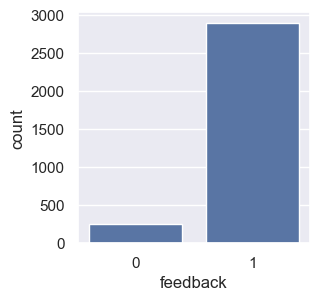

In [132]:
plt.figure(figsize=(3,3))
sns.countplot(x='feedback', data=df_sent)
plt.show()

In [124]:
df_sent['feedback'].value_counts()

feedback
1    2893
0     257
Name: count, dtype: int64

In [134]:
df_sent.shape

(3150, 2)

## Do Prediction for first 200 records only

In [238]:
df_final=df_sent['verified_reviews'].head(200).tolist()

In [240]:
df_final[2]

'Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.'

In [242]:
pred=classifier(df_final)

In [244]:
pred[:10]

[{'label': 'POSITIVE', 'score': 0.9998718500137329},
 {'label': 'POSITIVE', 'score': 0.9998828172683716},
 {'label': 'NEGATIVE', 'score': 0.6306113600730896},
 {'label': 'POSITIVE', 'score': 0.9997362494468689},
 {'label': 'POSITIVE', 'score': 0.9980834722518921},
 {'label': 'POSITIVE', 'score': 0.9989218711853027},
 {'label': 'NEGATIVE', 'score': 0.6005104184150696},
 {'label': 'POSITIVE', 'score': 0.9990399479866028},
 {'label': 'POSITIVE', 'score': 0.9998619556427002},
 {'label': 'POSITIVE', 'score': 0.9998669624328613}]

In [246]:
df_validation=df_sent.head(200)
df_validation['pred']=[1 if pred['label'].startswith('P') else 0 for pred in pred]

In [248]:
df_validation.head()

,verified_reviews,feedback,pred
0,Love my Echo!,1,1
1,Loved it!,1,1
2,"Sometimes while playing a game, you can answer...",1,0
3,I have had a lot of fun with this thing. My 4 ...,1,1
4,Music,1,1


In [250]:
df_validation['feedback'].value_counts()

feedback
1    194
0      6
Name: count, dtype: int64

In [252]:
df_validation['pred'].value_counts()

pred
1    164
0     36
Name: count, dtype: int64

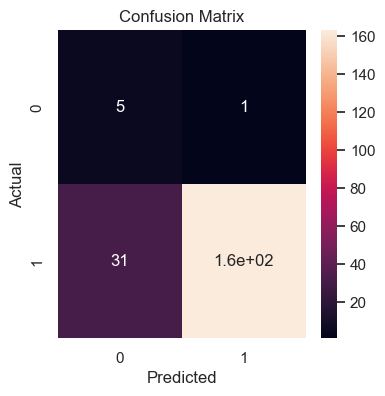

In [254]:
cm=confusion_matrix(df_validation['feedback'],df_validation['pred'])
plt.figure(figsize=(4,4))
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.title('Confusion Matrix')
plt.show()

In [256]:
probs=[pred['score'] if pred['label'].startswith('P') else 1-pred['score'] for pred in pred]

In [258]:
print(f"roc auc score:{roc_auc_score(df_validation['feedback'],probs)}")

roc auc score:0.9536082474226804


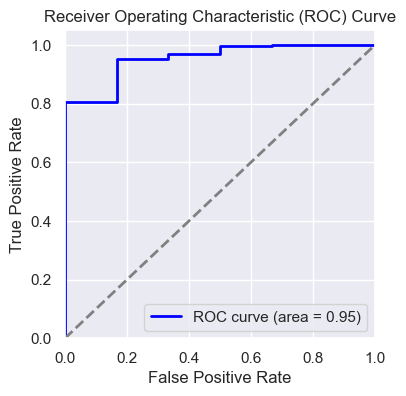

In [260]:
fpr, tpr, _ = roc_curve(df_validation['feedback'], probs) 
roc_auc = auc(fpr, tpr) 
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic (ROC) Curve') 
plt.legend(loc="lower right") 
plt.show()